In [23]:
import numpy as np
import pandas as pd
import yfinance as fyf
import statsmodels.tsa. stattools
import statsmodels.tsa.api as smt

from pandas import read_csv
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import tensorflow as tf
%matplotlib inline

keras = tf.keras

def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

stocks='QCOM'
stocks=stocks.split()
data = fyf.download(stocks, start = '2016-02-01', end = '2021-01-25')['Close']
data.tail()

[*********************100%***********************]  1 of 1 completed


Date
2021-01-15    157.089996
2021-01-19    163.770004
2021-01-20    164.600006
2021-01-21    164.750000
2021-01-22    162.419998
Name: Close, dtype: float64

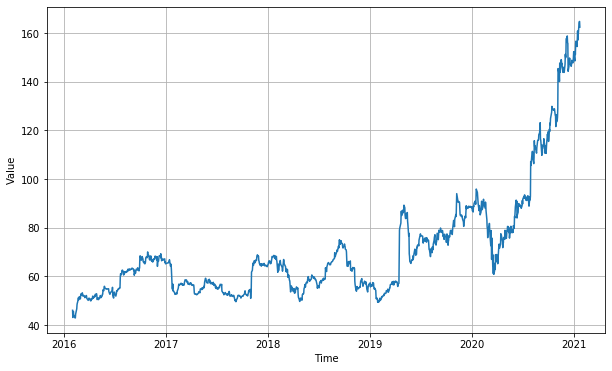

In [24]:
plt.figure(figsize=(10, 6))
plot_series(data.index, data.values)
plt.show()

### Moving Average forescast

First, we split the data into training and validation sets.

In [25]:
split_time = 1000
time_train = data.index[:split_time]
x_train = data.values[:split_time]
time_valid = data.index[split_time:]
x_valid = data.values[split_time:]

Now we start from a simple MA model which is a naive forecast based on past values, this will be our baseline model. Let window size be 30 days, so we predict future value based on the average of the past 30 days. 

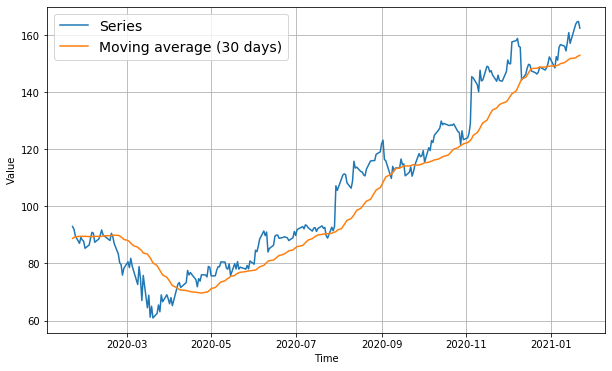

In [26]:
def moving_average_forecast(series, window_size):
    mov = np.cumsum(series)
    mov[window_size:] = mov[window_size:] - mov[:-window_size]
    return mov[window_size -1:-1] / window_size

moving_avg = moving_average_forecast(data.values, 30)[split_time-30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg, label="Moving average (30 days)")

Our time series has a steep trend, so let's try to remove it and see how the forecast will change.

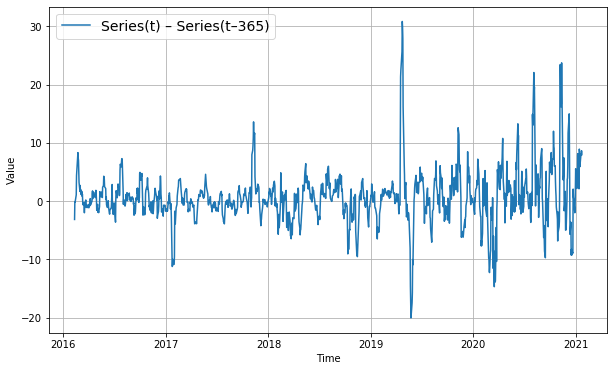

In [27]:
diff_series = (data.values[7:] - data.values[:-7])
diff_time = data.index[7:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series, label="Series(t) – Series(t–365)")
plt.show()

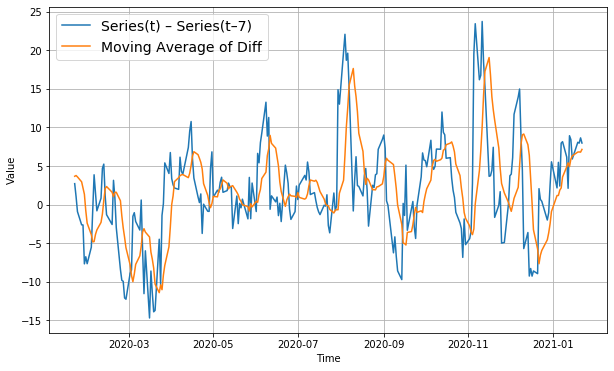

In [28]:
diff_moving_avg = moving_average_forecast(diff_series, 7)[split_time - 7 - 7:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 7:], label="Series(t) – Series(t–7)")
plot_series(time_valid, diff_moving_avg, label="Moving Average of Diff")
plt.show()

Let's bring back the trend by adding past values from t-7.

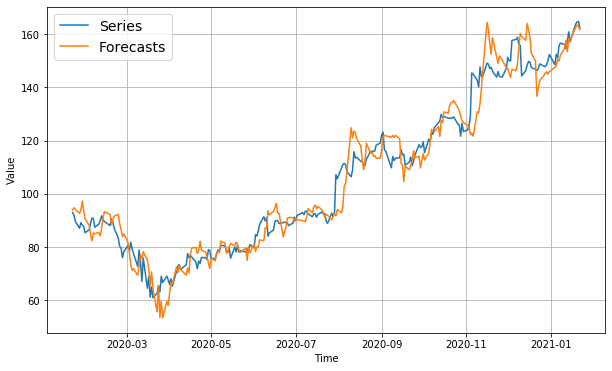

In [29]:
diff_moving_avg_plus_past = data.values[split_time - 7:-7] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_past, label="Forecasts")
plt.show()

In [30]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()

4.821142263165743

The above forecast looks good, although there's some noise coming from the past values of the series. Now let's use a moving averaging on past values to reduce the noise. 

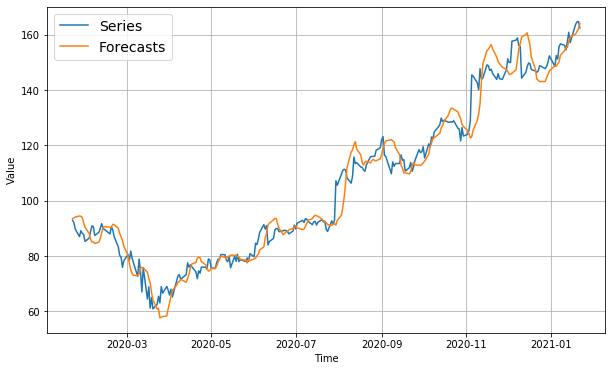

In [31]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(data.values[split_time - 10:-4], 6) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label="Forecasts")
plt.show()

In [32]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()

4.087172182481478

Looks better! So our baseline model has MAE of 4.08.

### RNN

We proceed with RNN. Here we do not pre-process the data by removing the trend, we use original time series.

In [33]:
%%capture
keras.backend.clear_session()
tf.random.set_seed(6)
np.random.seed(6)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal',
                     activation='relu', input_shape=[None, 1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
lambda epoch: 1e-8 * 10 ** (epoch /20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer, 
             metrics=['mae'])
history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule]);

[1e-08, 0.0001, 0, 30]

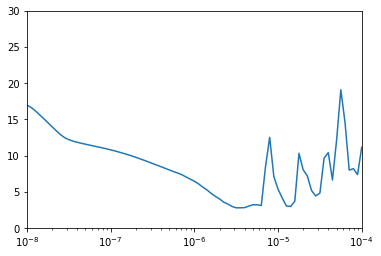

In [34]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

The optimal learning rate is about 1e-6, so let's try that. We will save the best model to use it further for forecasting. 

In [35]:
%%capture
keras.backend.clear_session()
tf.random.set_seed(6)
np.random.seed()

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                  batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)


model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    'my_checkpoint.h5', save_best_only = True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
         validation_data = valid_set,
         callbacks = [early_stopping, model_checkpoint]);

KeyboardInterrupt: 

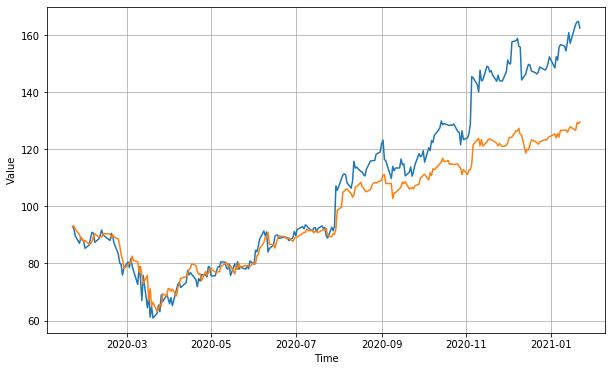

In [14]:
model = keras.models.load_model('my_checkpoint.h5')

rnn_forecast = model_forecast(model, data.values[:, np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
print(keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

9.207654


In [16]:
%%capture
keras.backend.clear_session()
tf.random.set_seed(6)
np.random.seed(6)

window_size = 60
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1,2,4,8,16,32):
    model.add(
        keras.layers.Conv1D(filters=32,
                           kernel_size=2,
                           strides=1,
                           dilation_rate=dilation_rate,
                           padding='causal',
                           activation='relu')
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
lambda epoch: 1e-4 * 10 ** (epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer, 
              metrics=['mae'])

history = model.fit(train_set, epochs=500, callbacks=[lr_schedule]);

 170ms/step - loss: 299433.0295 - mae: 299433.5260
Epoch 321/500
8/8 [==============================] - 2s 106ms/step - loss: 320791.7847 - mae: 320792.2812
Epoch 322/500
8/8 [==============================] - 1s 99ms/step - loss: 338374.2292 - mae: 338374.7257
Epoch 323/500
8/8 [==============================] - 1s 95ms/step - loss: 354806.1042 - mae: 354806.6632
Epoch 324/500
8/8 [==============================] - 2s 179ms/step - loss: 371357.7986 - mae: 371358.2847
Epoch 325/500
8/8 [==============================] - 1s 100ms/step - loss: 388667.5833 - mae: 388668.0799
Epoch 326/500
8/8 [==============================] - 2s 146ms/step - loss: 407088.6181 - mae: 407089.2083
Epoch 327/500
8/8 [==============================] - 1s 114ms/step - loss: 426845.8021 - mae: 426846.3299
Epoch 328/500
8/8 [==============================] - 1s 103ms/step - loss: 448105.0382 - mae: 448105.5347
Epoch 329/500
8/8 [==============================] - 2s 107ms/step - loss: 471016.3333 - mae: 471016.80

[0.0001, 0.1, 0, 30]

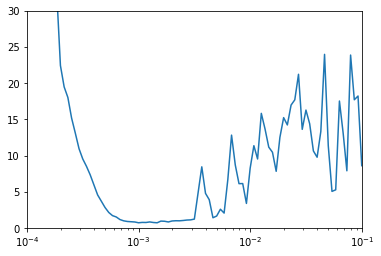

In [17]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-4, 1e-1, 0, 30])

In [18]:
%%capture
keras.backend.clear_session()
tf.random.set_seed(6)
np.random.seed(6)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1,2,4,8,16,32):
    model.add(
    keras.layers.Conv1D(filters=32,
                       kernel_size=2,
                       strides=1,
                       padding='causal',
                       activation='relu')
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer=keras.optimizers.Adam(lr=1e-3)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

model_checkpoint = keras.callbacks.ModelCheckpoint(
'my_checkpoint.h5', save_best_only = True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500, validation_data=valid_set,
                   callbacks=[early_stopping, model_checkpoint]);

Epoch 1/500
8/8 [==============================] - 2s 88ms/step - loss: 57.0638 - mae: 57.5638 - val_loss: 73.2442 - val_mae: 73.7442
Epoch 2/500
8/8 [==============================] - 1s 44ms/step - loss: 35.6078 - mae: 36.1074 - val_loss: 15.8763 - val_mae: 16.3737
Epoch 3/500
8/8 [==============================] - 0s 43ms/step - loss: 13.7486 - mae: 14.2474 - val_loss: 11.4660 - val_mae: 11.9574
Epoch 4/500
8/8 [==============================] - 0s 46ms/step - loss: 8.2505 - mae: 8.7448 - val_loss: 11.3689 - val_mae: 11.8618
Epoch 5/500
8/8 [==============================] - 0s 41ms/step - loss: 6.3107 - mae: 6.7985 - val_loss: 7.6563 - val_mae: 8.1386
Epoch 6/500
8/8 [==============================] - 0s 44ms/step - loss: 3.9982 - mae: 4.4606 - val_loss: 7.1075 - val_mae: 7.5872
Epoch 7/500
8/8 [==============================] - 1s 43ms/step - loss: 3.3956 - mae: 3.8352 - val_loss: 5.8703 - val_mae: 6.3400
Epoch 8/500
8/8 [==============================] - 0s 45ms/step - loss: 2.80

In [19]:
model = keras.models.load_model("my_checkpoint.h5")

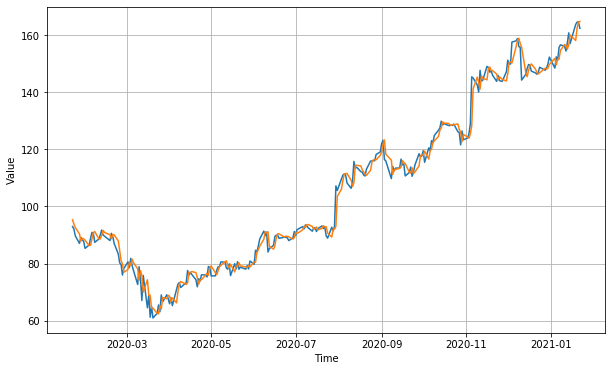

In [20]:
cnn_forecast = model_forecast(model, data.values[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)


In [21]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

2.1230183

In [50]:
%%capture
cnn_forecast = model_forecast(model, data.values[..., np.newaxis], window_size)

array([ 94.9563  ,  93.572556,  92.714096,  90.58777 ,  88.11644 ,
        89.142586,  88.82345 ,  88.144875,  86.393684,  86.59979 ,
        88.72218 ,  90.58479 ,  90.88589 ,  88.50981 ,  88.75078 ,
        90.05255 ,  91.46033 ,  90.71369 ,  90.03174 ,  88.852684,
        90.270454,  90.06703 ,  87.87966 ,  84.77587 ,  81.542465,
        80.38967 ,  77.37716 ,  78.22438 ,  80.5035  ,  79.2247  ,
        81.39746 ,  80.22656 ,  78.1485  ,  74.478714,  77.71423 ,
        75.852875,  70.64645 ,  74.897766,  69.91461 ,  69.287796,
        65.131645,  64.89065 ,  62.896694,  62.492363,  65.42849 ,
        63.897324,  67.77307 ,  67.352806,  68.504135,  68.48886 ,
        66.616486,  68.087585,  66.35064 ,  69.76733 ,  72.4858  ,
        73.1497  ,  72.3727  ,  73.28492 ,  76.85663 ,  76.48167 ,
        76.91098 ,  76.8222  ,  75.0822  ,  72.96583 ,  74.518486,
        74.43158 ,  75.761185,  76.4422  ,  75.73176 ,  78.49495 ,
        79.03229 ,  76.61461 ,  76.235695,  77.63006 ,  78.823